In this notebook, I have used strategy which combines RSI 14 and MACD 12 26 9. Also used 15 days UpperBound and LowerBound to analyse entry and exit point.


First i have installed few libraries yfinance for downloading financial data, pandas and numpy for data manipulation and analysis. matplot for plotting the graph

In [1]:
!pip install yfinance pandas matplotlib
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Stored top 5 NIFTY companies according to market capitalization in a list

In [2]:
companies = ['RELIANCE.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS', 'TCS.NS']

Wrote function to calculate standard RSI 14 and MACD which I feel when combined together works well in long term investement decisions.
RSI tells about whether the stock os oversold or overbought. However it may provide false signal when used alone whereas MACD can be used to validate trend direction

In [3]:
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_macd(prices, fast=12, slow=26, signal=9):
    exp1 = prices.ewm(span=fast, adjust=False).mean()
    exp2 = prices.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

I used for loop to download data of each company one by one and calculated UperBound and LowerBound of last 15 days excluding today, MACD and RSI.
Entry Condition:
Entry is made when 3 conditions are met simultaneously i.e. price crosses UpperBound by 0.5% and MACD line>signal line(Indicates positive momentum) and RSI<75 which ensures that stock is not overbrought. First I kept RSI<50 but It made fewer entries and less profit as all three conditions together are quiet strict.
Entry is also made when RSI reaches below 14 as it indicates that the stock is oversold probably due to temprory crash.
Exit is made when MACD line goes below signal line which is an indicator of negative momentum or price goes below lower band more than 0.5%.
I made the graph using various values of RSI, UpperBand, LowerBand, etc. to get close to maximum profit.


Impact of various conditions:  
1. Buy if price go above UpperBound by 0.5% final portfolio value: 341893 vs if 0.5% criteria is not there final portfolio value: 129538
Adding 0.5% condition gives a strong confirmation in buy signal
2. Similarly for LowerBand condition. However the impact on final value is not so high in this condition as other indicator act more prominently for exit trade.
3. Adding a 0.5% criteria to the MACD indicator has also created a value difference of approx 30000 in the final value of portfolio for which the reason is similar that it makes the confirmation more supporting.
4. Adding retest_cond has increased the portfolio value from 329716 to 341893, this startegy is basically confirming buy signal if price goes above UpperBand backed by Volume

In [4]:
processed = {}
for company in companies:
    df = yf.download(company, start='2020-04-01', end='2025-04-01')
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    lookback = 15
    df['UpperBand'] = df['High'].shift(1).rolling(window=lookback).max()
    df['LowerBand'] = df['Low'].shift(1).rolling(window=lookback).min()
    df['RSI'] = calculate_rsi(df['Close'])
    df['MACD'], df['MACD_Signal'] = calculate_macd(df['Close'])
    df['Signal'] = 0
    entry_cond = (
        (df['Close'] > df['UpperBand']*0.005) &
        (df['RSI'] < 75) &
        (df['MACD'] > df['MACD_Signal'])
    )
    retest_cond = (
    (df['Close'] > df['UpperBand']) &
    (df['Volume'] > df['Volume'].rolling(30).mean())  # Volume confirmation
    )
    # Combined entry signal
    df.loc[(entry_cond) | (df['RSI'] < 14) | (retest_cond), 'Signal'] = 1
    exit_cond = (
        (df['Close'] < df['LowerBand']*0.995) |
        (df['MACD'] < df['MACD_Signal']*0.995)
    )
    df.loc[exit_cond, 'Signal'] = -1
    processed[company] = df.dropna(subset=['UpperBand', 'LowerBand'])

C:\Users\Karan Dhayal\AppData\Local\Temp\ipykernel_44444\393175090.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(company, start='2020-04-01', end='2025-04-01')
[*********************100%***********************]  1 of 1 completed
C:\Users\Karan Dhayal\AppData\Local\Temp\ipykernel_44444\393175090.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(company, start='2020-04-01', end='2025-04-01')
[*********************100%***********************]  1 of 1 completed
C:\Users\Karan Dhayal\AppData\Local\Temp\ipykernel_44444\393175090.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(company, start='2020-04-01', end='2025-04-01')
[*********************100%***********************]  1 of 1 completed
C:\Users\Karan Dhayal\AppData\Local\Temp\ipykernel_44444\393175090.py:3: FutureWarning: YF.download() has changed argument auto_adjust default

1. First I divided the cash into five equal parts for each company but that was very ineffective and loss making then I thought why not allocate cash dynamically.
2. I divided the cash into n equal parts and invested the free cash into a company whenever the Buy signal is there because the problem in dividing cash equally for each comapny statically is that cash is free and not in position for very large time. It was one of the major change which made significant impact in returns.
3. Risk Management: I added 5% stoploss to limit my losses. Also added 8% target price which is a bit less than twice of stoploss to secure profit. I also added trailling stop loss of 3%. So, that I can protect my profits against downard trends.
4. I printed every trade to analyse the factors to increase my alpha and the results are listed in above markdown cell.
5. Finally, achieved a CAGR of 27.87%

In [5]:
initial_cash = 100000
sl_pct = 0.05
tp_pct = 0.08
tsl_pct = 0.03
n = 1
cash_parts = [initial_cash / n]*n 
positions = [None]*n  
portfolio = []
dates = sorted(set().union(*[df.index for df in processed.values()]))
for date in dates:
    for i in range(n):
        pos = positions[i]
        if pos is not None:
            company, entry_price, shares, sl, tp, max_price = pos
            if date not in processed[company].index:
                continue
            row = processed[company].loc[date]
            price = row['Close']
            # Trailing SL update
            if price > max_price:
                max_price = price
                sl = max(sl, max_price * (1 - tsl_pct))
            # Exit logic
            exit_trade = False
            if row['Signal'] == -1:
                exit_trade = True
                reason = 'signal'
            elif price<=sl:
                exit_trade = True
                reason = 'Stop Loss hit'
            elif price >= tp:
                exit_trade = True
                reason = 'Target Price hit'
            if exit_trade:
                cash_parts[i] += shares * price
                positions[i] = None
                print('Sell',company,date,price//1,' ', reason)
            else:
                positions[i] = (company, entry_price, shares, sl, tp, max_price)
    for i in range(n):
        if positions[i] is not None:
            continue
        for company in companies:
            if date not in processed[company].index:
                continue
            row = processed[company].loc[date]
            if row['Signal'] == 1:
                price = row['Close']
                shares = int(cash_parts[i] // price)
                if shares > 0:
                    cash_parts[i] -= shares * price
                    sl = price * (1 - sl_pct)
                    tp = price * (1 + tp_pct)
                    positions[i] = (company, price, shares, sl, tp, price)
                    print('Buy',company,date,price//1)
                    break
    total = sum(cash_parts)
    for pos in positions:
        if pos is not None:
            company, entry_price, shares, sl, tp, max_price = pos
            if date in processed[company].index:
                price = processed[company].loc[date]['Close']
                total += shares * price
    portfolio.append(total)
print(total)
def CAGR(initial_value, final_value, years):
    cagr = (((final_value/initial_value)**(1/years))-1)*100
    return cagr
cagr = CAGR(initial_cash,total,5)
print(f"CAGR={cagr:.2f}%")

Buy HDFCBANK.NS 2020-04-28 00:00:00 896.0
Sell HDFCBANK.NS 2020-05-04 00:00:00 909.0   Stop Loss hit
Buy HDFCBANK.NS 2020-05-04 00:00:00 909.0
Sell HDFCBANK.NS 2020-05-06 00:00:00 872.0   signal
Buy INFY.NS 2020-05-06 00:00:00 598.0
Sell INFY.NS 2020-05-14 00:00:00 583.0   signal
Buy RELIANCE.NS 2020-05-14 00:00:00 672.0
Sell RELIANCE.NS 2020-05-15 00:00:00 661.0   signal
Buy TCS.NS 2020-05-15 00:00:00 1723.0
Sell TCS.NS 2020-05-18 00:00:00 1715.0   signal
Buy TCS.NS 2020-05-22 00:00:00 1778.0
Sell TCS.NS 2020-06-12 00:00:00 1814.0   signal
Buy HDFCBANK.NS 2020-06-12 00:00:00 881.0
Sell HDFCBANK.NS 2020-06-15 00:00:00 919.0   signal
Buy ICICIBANK.NS 2020-06-15 00:00:00 332.0
Sell ICICIBANK.NS 2020-06-17 00:00:00 330.0   signal
Buy RELIANCE.NS 2020-06-17 00:00:00 736.0
Sell RELIANCE.NS 2020-06-22 00:00:00 812.0   Target Price hit
Buy RELIANCE.NS 2020-06-22 00:00:00 812.0
Sell RELIANCE.NS 2020-07-14 00:00:00 889.0   Target Price hit
Buy INFY.NS 2020-07-14 00:00:00 711.0
Sell INFY.NS 2020

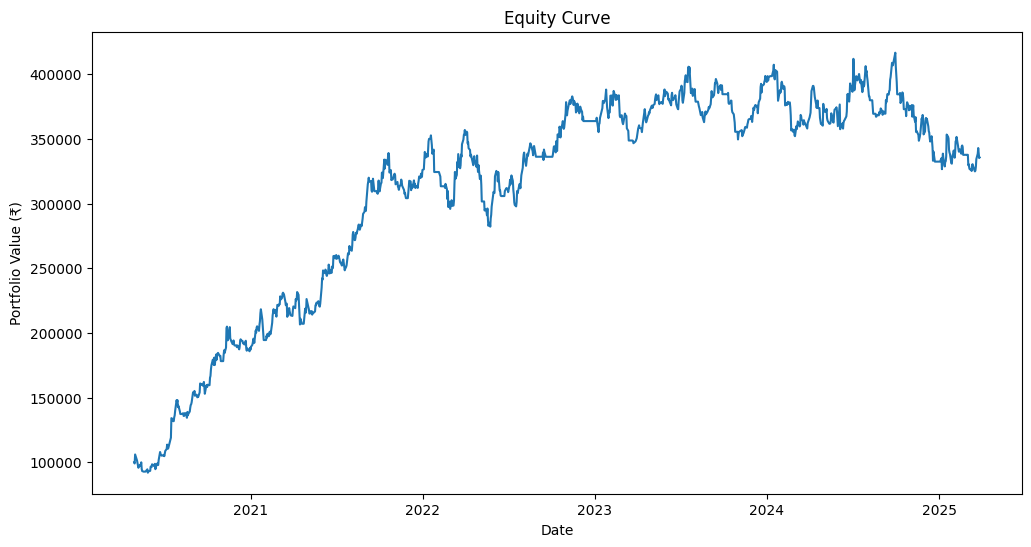

In [6]:
#Equity Curve
results = pd.DataFrame(index=dates)
results['Portfolio'] = portfolio

plt.figure(figsize=(12,6))
plt.plot(results.index, results['Portfolio'])
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (₹)')
plt.show()

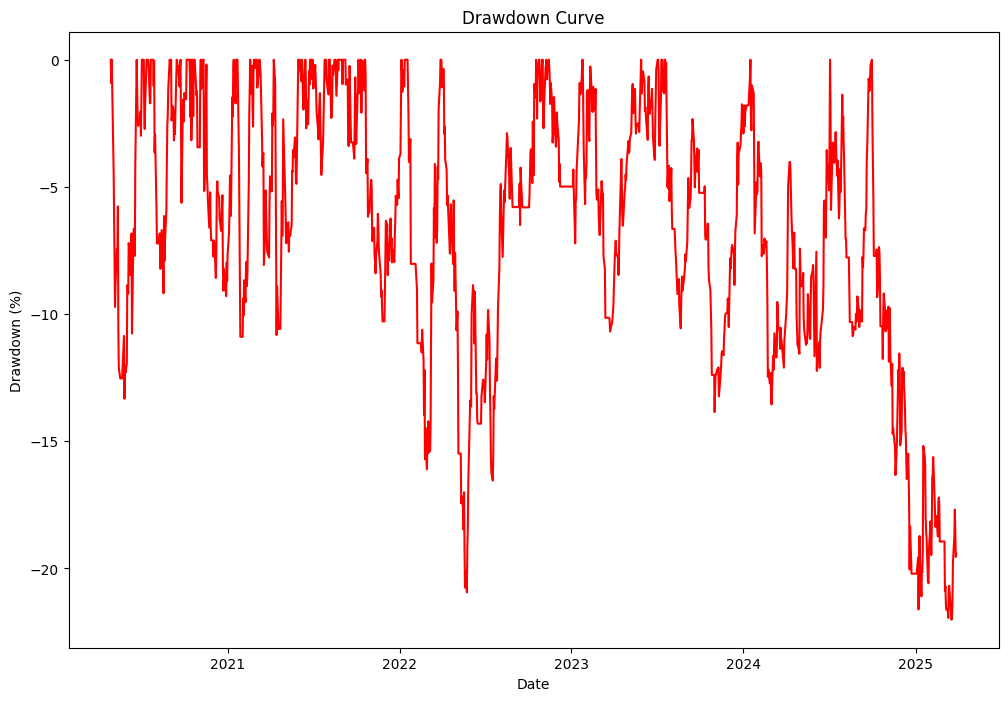

In [7]:
#Drawdown Curve
results['Peak'] = results['Portfolio'].cummax()
results['Drawdown'] = ((results['Portfolio'] - results['Peak'])/results['Peak'])*100

plt.figure(figsize=(12,8))
plt.plot(results.index, results['Drawdown'], color='red')
plt.title('Drawdown Curve')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.show()